# JetSeT - basic physical setup

#### This notebook presents how to initialize the basic physical properties to compute an SSC model in JetSeT. We will show how the electron distribution can be defined and how one can access the model parameters.

In [1]:
#Some initial imports
import numpy as np
import matplotlib.pyplot as plt 

from jetset.jet_model import Jet
from jetset.plot_sedfit import PlotSED

In [2]:
#Show available electron distributions
Jet.available_electron_distributions()

lp: log-parabola
pl: powerlaw
lppl: log-parabola with low-energy powerlaw branch
lpep: log-parabola defined by peak energy
plc: powerlaw with cut-off
bkn: broken powerlaw
superexp: powerlaw with super-exp cut-off


Let's try a few different distributions (number of electrons vs energy). For example, let's start with the "bkn" one:

===> setting C threads to 8


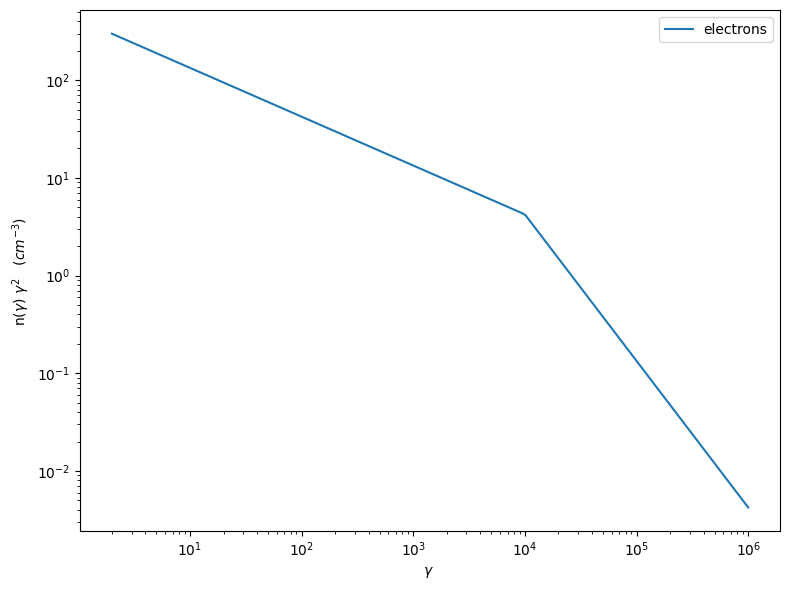

In [3]:
#First, we define a jet instance, selecting a broken power-law distribution
my_jet=Jet(name='test',electron_distribution='bkn')

#and then plot the gamma^2*dn/dE distribution
my_jet.electron_distribution.plot2p()

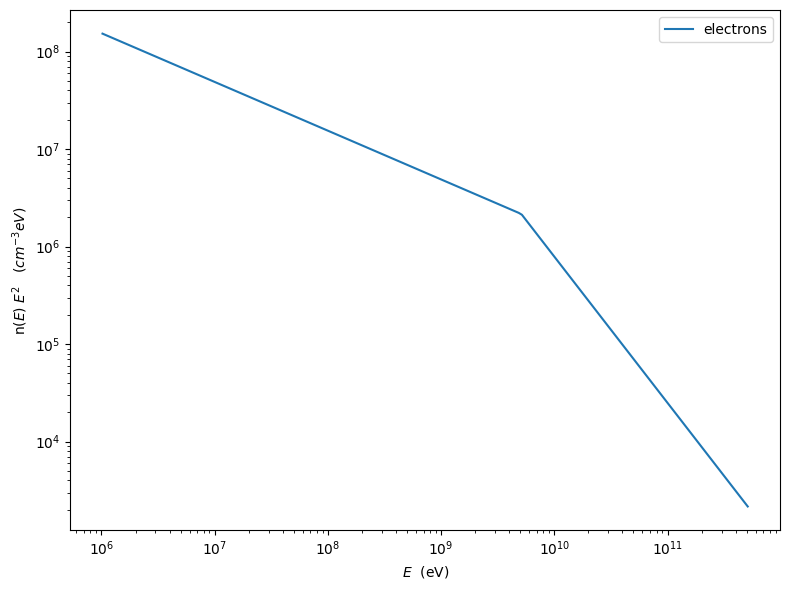

In [4]:
#The energy units can also be changed, for example 'eV' 
my_jet.electron_distribution.plot2p(energy_unit='eV')

Instead of using a predefined distribution shape, a **custom distribution** can be defined. As an example let us consider a broken power-law with a high-energy exponential cutoff (which is physically more sensible than a broken power-law with "sharp" cut-off at high-energies).

\begin{equation}
    \frac{dn_{\rm e}}{d\gamma}(\gamma)\propto \begin{cases}
    \gamma^{-p}, \; \gamma_{\rm min} < \gamma < \gamma_{\rm br},\\
    \gamma^{-p_1} \; e^{-\gamma/\gamma_{\rm cut}}, \; \gamma > \gamma_{\rm br},
    \end{cases}
\end{equation}

In [5]:
from numba import jit
@jit(forceobj=True)#tells Numba to compile the function below in "object" mode to use the np.heavyside() function

def brokenpowerlaw_expcutoff(gamma, p, p_1, gamma_br, gamma_cut):
    #power-law branch before the break
    ne_below_break = (gamma)**(-p) * np.heaviside(gamma_br-gamma, 1)
    #power-law + exp cut-off after the break (the last two terms are just here to get a proper normalization)
    ne_above_break = (gamma)**(-p_1) * np.exp(-gamma/gamma_cut) * np.heaviside(gamma-gamma_br, 1) *\
                     (gamma_br)**(p_1-p) * np.exp(gamma_br/gamma_cut)
    
    return ne_below_break+ne_above_break


Once the distribution is defined, we can include it in JetSeT with `EmittersDistribution()` and then add each parameter:

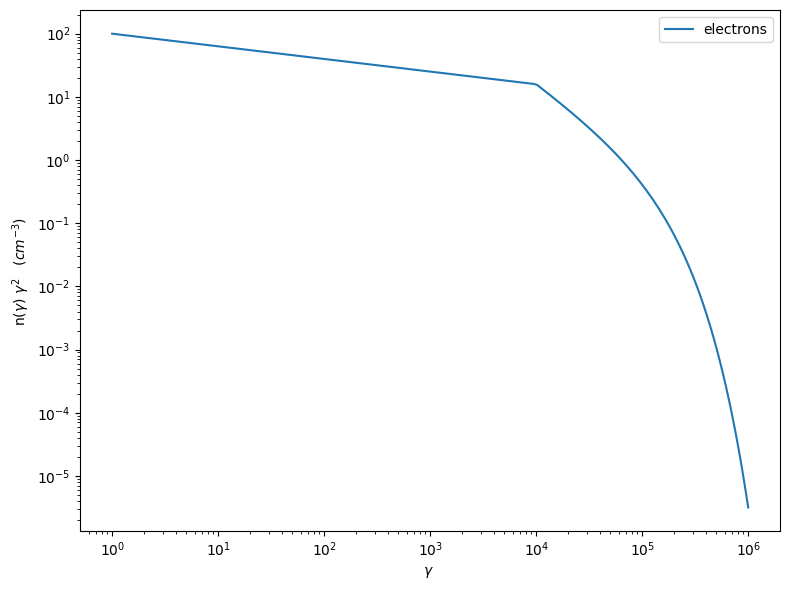

In [6]:
from jetset.jet_emitters import EmittersDistribution

n_e_bkn_expcut = EmittersDistribution('bkn_expcutoff', spectral_type='user_defined')
n_e_bkn_expcut.add_par('p', par_type='LE_spectral_slope', val=2.3,vmin=-10., vmax=10, unit='')
n_e_bkn_expcut.add_par('p_1', par_type='HE_spectral_slope', val=3.3,vmin=-10., vmax=10, unit='')
n_e_bkn_expcut.add_par('gamma_br', par_type='turn-over-energy', val=1e5,vmin=0., vmax=1e15, unit='lorentz-factor')
n_e_bkn_expcut.add_par('gamma_cut', par_type='high-energy-cut-off', val=1e6,vmin=1., vmax=1e9, unit='lorentz-factor')

n_e_bkn_expcut.set_distr_func(brokenpowerlaw_expcutoff)

n_e_bkn_expcut.parameters.p.val=2.2
n_e_bkn_expcut.parameters.p_1.val=3.2
n_e_bkn_expcut.parameters.gamma_br.val=1e4
n_e_bkn_expcut.parameters.gamma_cut.val=1e5
n_e_bkn_expcut.parameters.gmax.val=1e6
n_e_bkn_expcut.parameters.gmin.val=1e0

n_e_bkn_expcut.plot2p()

Let's initialize a new `Jet` object, with the `n_e_bkn_expcut` particle distribution

In [7]:
my_jet = Jet(name='test',electron_distribution=n_e_bkn_expcut)

===> setting C threads to 8
===> function already jitted


In [8]:
my_jet.show_model()


--------------------------------------------------------------------------------
model description: 
--------------------------------------------------------------------------------
type: Jet
name: test  
geometry: spherical  

electrons distribution:
 type: bkn_expcutoff  
 gamma energy grid size:  201
 gmin grid : 1.000000e+00
 gmax grid : 1.000000e+06
 normalization:  False
 log-values:  False
 ratio of cold protons to relativistic electrons: 1.000000e+00

radiative fields:
 seed photons grid size:  100
 IC emission grid size:  100
 source emissivity lower bound :  1.000000e-120
 spectral components:
   name:Sum, state: on
   name:Sum, hidden: False
   name:Sync, state: self-abs
   name:Sync, hidden: False
   name:SSC, state: on
   name:SSC, hidden: False
external fields transformation method: blob

SED info:
 nu grid size jetkernel: 1000
 nu size: 500
 nu mix (Hz): 1.000000e+06
 nu max (Hz): 1.000000e+30

flux plot lower bound   :  1.000000e-30

-----------------------------------

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
test,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
test,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
test,B,magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,False
test,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True
test,beam_obj,beaming,,1.000000e+01,1.000000e-04,--,False,False
test,z_cosm,redshift,,1.000000e-01,0.000000e+00,--,False,False
test,gmin,low-energy-cut-off,lorentz-factor*,1.000000e+00,1.000000e+00,1.000000e+09,False,False
test,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
test,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
test,p,LE_spectral_slope,,2.200000e+00,-1.000000e+01,1.000000e+01,False,False


--------------------------------------------------------------------------------


## Setting values of the model parameters

In [9]:
#First method
my_jet.set_par('z_cosm',val=0.034)

my_jet.set_par('beam_obj',val=20)
my_jet.set_par('B',val=0.2)
my_jet.set_par('R',val=1E16)

my_jet.set_par('gmin',val=1E0)
my_jet.set_par('gamma_br',val=1E5)
my_jet.set_par('gamma_cut',val=1E6)
my_jet.set_par('gmax',val=1E7)
my_jet.set_par('N',val=1E3)
my_jet.set_par('p',val=2.0)
my_jet.set_par('p_1',val=3.0)


In [10]:
#Second method
my_jet.parameters.z_cosm.val=0.034

my_jet.parameters.beam_obj.val=20
my_jet.parameters.B.val=0.140
my_jet.parameters.R.val=3e15

my_jet.parameters.gmin.val=1E0
my_jet.parameters.gamma_br.val=1E5
my_jet.parameters.gamma_cut.val=1E6
my_jet.parameters.gmax.val=1E7
my_jet.parameters.N.val=2e3
my_jet.parameters.p.val=2.0
my_jet.parameters.p_1.val=3.0

We can now evaluate the model and plot it

20.3 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


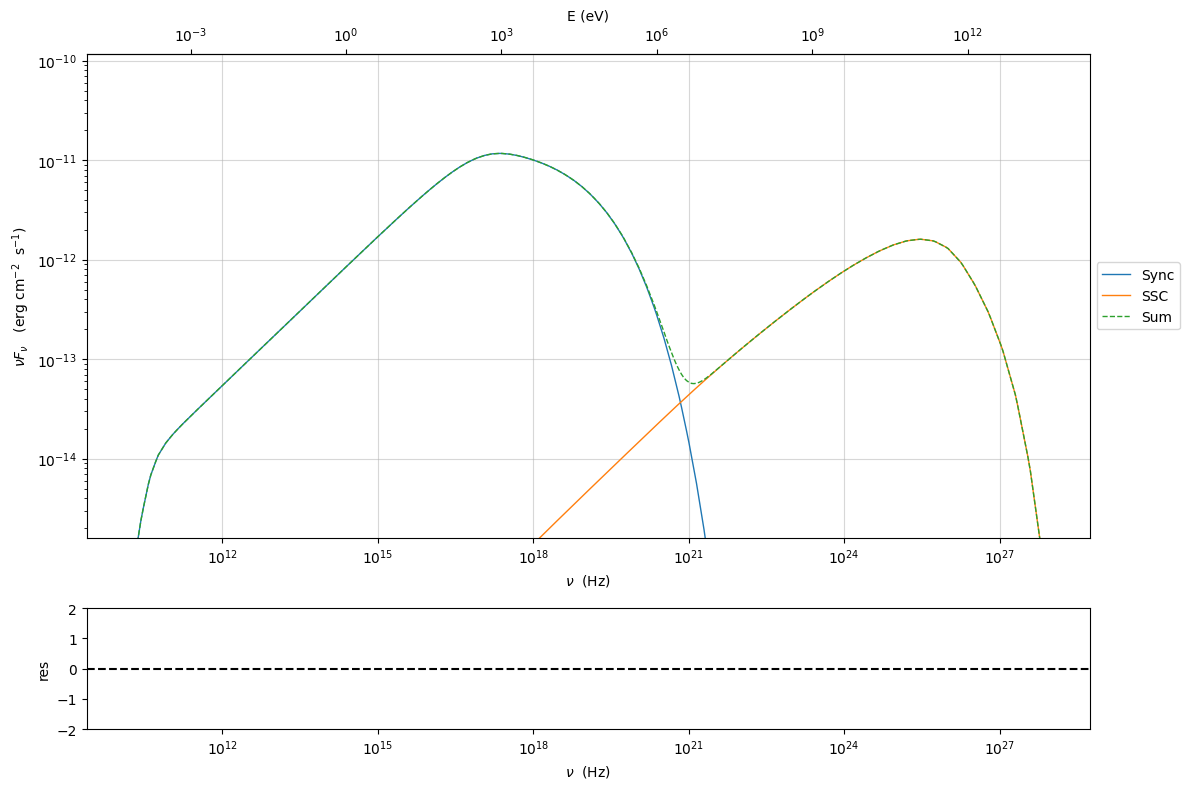

In [11]:
%timeit my_jet.eval()

my_plot = PlotSED()#this creates a plotting object
my_jet.plot_model(plot_obj=my_plot)

## Effect of model parameters on the SED shape
Let's play around with the different parameters and try to understand what is happening.

#### $\delta$ changes

First, let's see what happens under a change of $\delta$, the Doppler factor of the emitting region. At the same time, we keep track of the peak luminosity and frenquency using the `my_jet.get_component_peak()` method to diagnose the changes in the SED.

===> setting C threads to 8
===> function already jitted


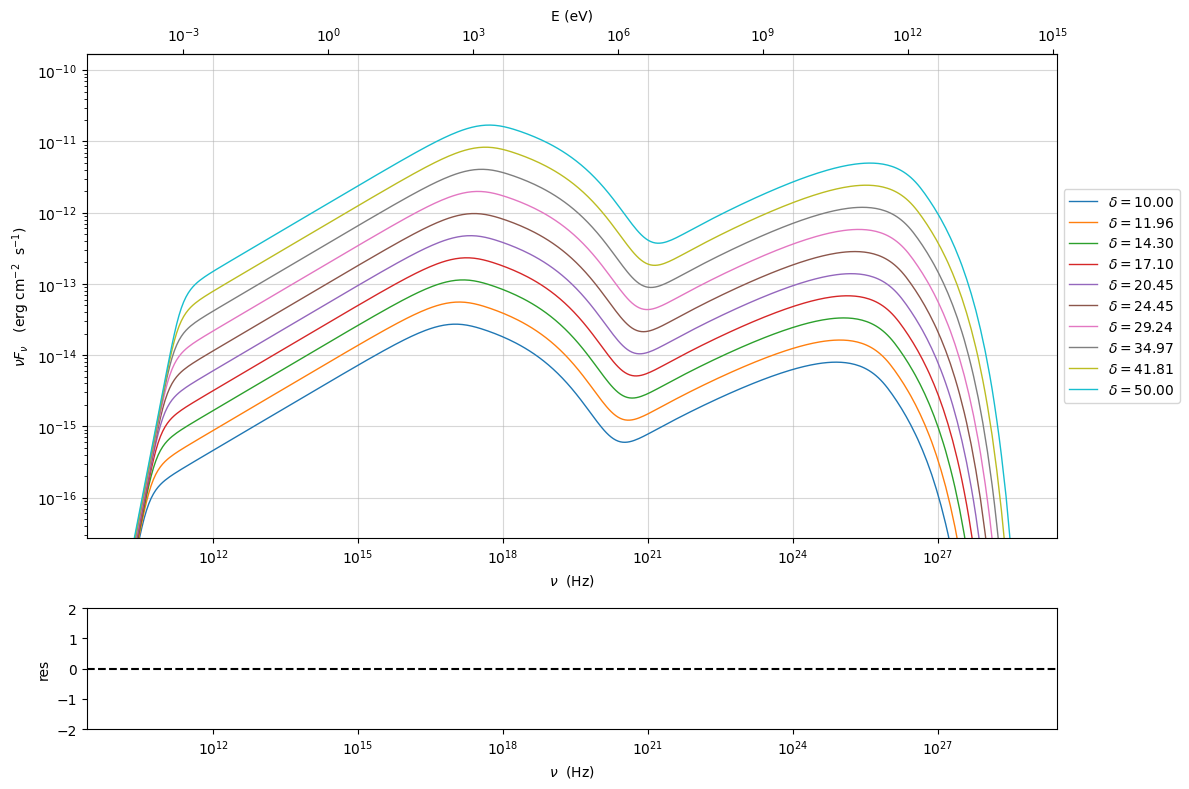

In [12]:
my_jet=Jet(name='delta_scan',electron_distribution=n_e_bkn_expcut)
my_jet.set_par('B',val=0.2)
my_jet.set_par('gmin',val=1E0)
my_jet.set_par('gamma_br',val=1E5)
my_jet.set_par('gamma_cut',val=1E6)
my_jet.set_par('gmax',val=1E7)
my_jet.set_par('R',val=1e15)
my_jet.set_par('N',val=1E5)

delta_scanned_values = np.geomspace(10, 50, num=10)

#create empty list to store the peak luminosity and frequencies.
peak_flux = []
peak_frequency = []

#create plotting objects
delta_scan=PlotSED()

for delta in delta_scanned_values:
    my_jet.set_par('beam_obj',val=delta)
    
    my_jet.nu_seed_size = 1000
    my_jet.set_IC_nu_size(1000)
    
    my_jet.eval()

    my_jet.plot_model(plot_obj=delta_scan,label=fr'$\delta={delta:.2f}$',comp='Sum')
   
    x_p,y_p = my_jet.get_component_peak('Sync',log_log=True)
    peak_flux.append(y_p)
    peak_frequency.append(x_p)

The emission is expected to follow a $\propto \delta^4$ relationship as a result of relativistic Doppler boosting:
<div align="center">
$$
\nu F_{\rm \nu}(\nu) = \delta^4 \, \nu' F'_{\rm \nu'}(\nu')
$$
</div>
And we can now verified this trend by plotting the synchrotron peak flux ($\nu_{sync, p} F_{\nu} (\nu_{sync, p})$) versus $\delta$.

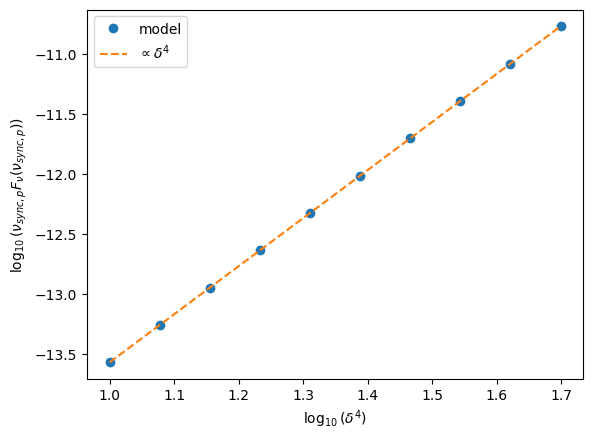

In [13]:
plt.figure()
plt.plot(np.log10(delta_scanned_values), peak_flux, 'o', label='model')
plt.plot(np.log10(delta_scanned_values), 4*np.log10(delta_scanned_values)+peak_flux[0]-4*np.log10(delta_scanned_values[0]), 
        linestyle='--', label=r'$\propto \delta^4$')

plt.xlabel(r'$\log_{10}(\delta^4$)')
plt.ylabel(r'$\log_{10}(\nu_{sync, p} F_{\nu} (\nu_{sync, p})$)')
plt.legend()


#### $\gamma_{br}$ changes

Now, let's see how the SED peaks behave under changes of $\gamma_{br}$, the break Lorentz factor.<br> 
We define $\nu_{\rm sync, p}$, $\nu_{\rm IC, p}$ as the synchrotron and inverse-Compton peak frequencies, and  $\nu_{sync, p} F_{\nu}(\nu_{sync, p})$,  $\nu_{IC, p} F_{\nu}(\nu_{IC, p})$ the corresponding peak fluxes.

In the synchrotron component, we expect the following relationship for the peak frequency under changes of $\gamma_{\rm br}$, $B$ and $\delta$:
<div align="center">
$$
\nu_{sync, p} \approx 3.7 \cdot 10^{6} \; \gamma^2_{\rm br} \; B \; \delta \quad {\rm Hz}
$$
</div>

===> setting C threads to 8


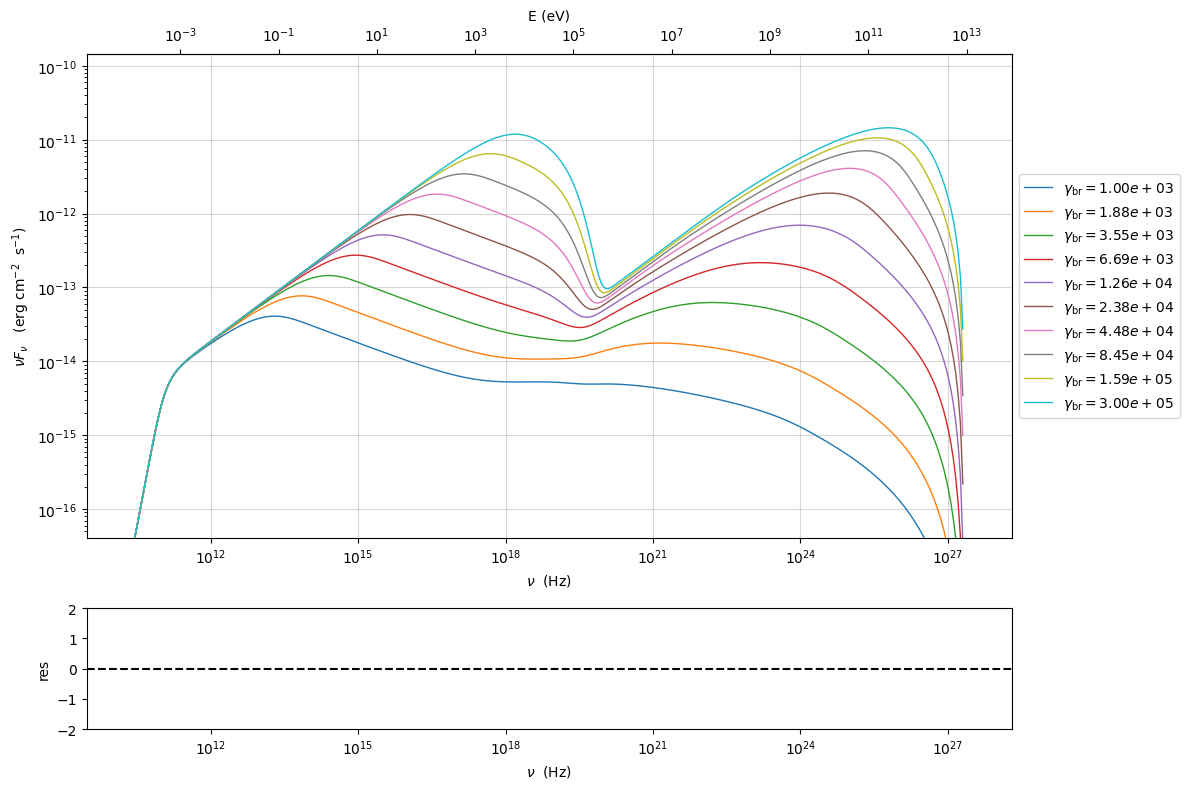

In [14]:
my_jet=Jet(name='gamma_br_scan',electron_distribution='bkn')
my_jet.set_par('beam_obj',val=20)
my_jet.set_par('R',val=1e15)
my_jet.set_par('B',val=0.2)
my_jet.set_par('gmin',val=1E0)
my_jet.set_par('gmax',val=1E6)
my_jet.set_par('p',val=2.)
my_jet.set_par('p_1',val=3.5)
my_jet.set_par('N',val=1E5)

#we scan a range of gamma_break values
gamma_br_scanned_values = np.geomspace(1e3, 3e5, num=10)

#create empty list to store the peak luminosity and frequencies of each component.
peak_frequency = []
peak_flux = []

peak_frequency_ssc = []
peak_flux_ssc = []

#create plotting objects
gamma_br_scan=PlotSED()

for gamma_br in gamma_br_scanned_values:
    my_jet.set_par('gamma_break',val=gamma_br)

    my_jet.nu_seed_size = 1000
    my_jet.set_IC_nu_size(1000)

    my_jet.eval()

    my_jet.plot_model(plot_obj=gamma_br_scan,label=r'$\gamma_{\rm br}$'+f'$={gamma_br:.2e}$', comp='Sum')
   
    x_p,y_p = my_jet.get_component_peak('Sync',log_log=True)
    x_p_SSC,y_p_SSC = my_jet.get_component_peak('SSC',log_log=True)
    
    peak_frequency.append(x_p)
    peak_flux.append(y_p) 

    peak_frequency_ssc.append(x_p_SSC)
    peak_flux_ssc.append(y_p_SSC) 

peak_frequency = np.asarray(peak_frequency)
peak_flux = np.asarray(peak_flux)

peak_frequency_ssc = np.asarray(peak_frequency_ssc)
peak_flux_ssc = np.asarray(peak_flux_ssc)

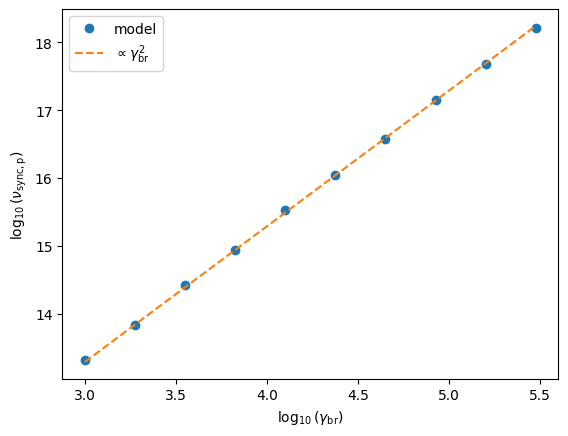

In [15]:
plt.figure()
plt.plot(np.log10(gamma_br_scanned_values), peak_frequency, 'o', label='model')
plt.plot(np.log10(gamma_br_scanned_values), 2*np.log10(gamma_br_scanned_values)+peak_frequency[1]-2*np.log10(gamma_br_scanned_values[1]), 
        linestyle='--', label=r'$\propto \gamma^2_{\rm br}$')

plt.xlabel(r'$\log_{10}(\gamma_{\rm br}$)')
plt.ylabel(r'$\log_{10}(\nu_{\rm sync, p}$)')
plt.legend()

## Tracking the $\nu_{\rm IC, p} / \nu_{\rm sync, p}$ ratio


An other important trend to investigate is the ratio between the two peak frequencies, $\nu_{\rm IC, p} / \nu_{\rm sync, p}$. Indeed, the latter quantity encode information about the regime in which the inverse-Compton scattering takes place, Thomson regime or Klein-Nishina (KN) regime. Please see [Tavecchio F. et al. 1998, ApJ, 509, 608](https://ui.adsabs.harvard.edu/abs/1998ApJ...509..608T/abstract) for more details on the relationships presented below.<br>

As a recap, the Thomson and KN regimes are determined by the ratio between the energy of the photon (being up-scattered) and the electron mass:<br>
<u>Thomson regime:<u/> <br>

$h \nu' << m_e c^2$ ($\nu'$ the energy of the photon in the electron rest frame) <br>

<u>KN regime<u/> <br>

$h \nu' \gtrsim m_e c^2$ ($\nu'$ the energy of the photon in the electron rest frame) <br> 


In the Thomson regime we expect the following behavior of $\nu_{IC, p}$ as function of $\gamma_{\rm br}$ and $\nu_{sync, p}$:
<div align="center">
$$
\nu_{IC, p} \approx \frac{4}{3} \; \gamma^2_{\rm br} \; \nu_{sync, p}
$$
</div>

While in the KN, inverse-Compton scattering is less efficient and we have a linear dependence on $\gamma_{\rm br}$:

<div align="center">
$$
\nu_{IC, p} \approx \frac{m c^2}{h} \; g(p, p_1) \; \gamma_{\rm br} \; \delta
$$
</div>
where $g(p, p_1)$ is a factor smaller than one depending on the electron distribution index below and above $\gamma_{\rm br}$. 

Thus, depending on the regime, the ratio $\nu_{\rm IC, p} / \nu_{\rm sync, p}$ behaves as<br>

<u>Thomson regime:<u/>
<div align="center">
$$
\frac{\nu_{IC, p}}{\nu_{sync, p}} \propto \gamma^2_{\rm br}
$$
</div>
<div align="center">
$$
\frac{\nu_{IC, p}}{\nu_{sync, p} \gamma^2_{\rm br}} \propto {\rm const}
$$
</div>

<u>KN regime<u/> <br>

<div align="center">
$$
\frac{\nu_{IC, p}}{\nu_{sync, p}} \propto \gamma^{-1}_{\rm br} \; B^{-1}
$$
</div>
<div align="center">
$$
\frac{\nu_{IC, p}}{\nu_{sync, p}\gamma^2_{\rm br}} \propto \gamma^{-3}_{\rm br} \; B^{-1}
$$
</div>
where we used $\nu_{sync, p} \propto \gamma^2_{\rm br} \; B \; \delta$ (see cells above):

So let's verify these trends by computing $\frac{\nu_{IC, p}}{\nu_{sync, p}\gamma^2_{\rm br}}$ (that we call `frequency_ratio_gamma2`) as fucntion of $\gamma_{\rm br}$. This will give us important information on the transition between the Thomson and KN regimes.

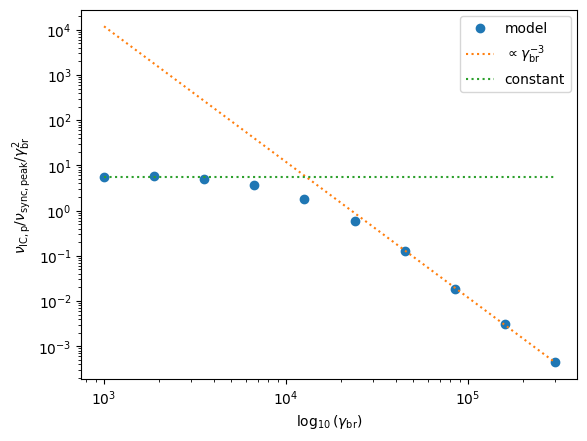

In [16]:
frequency_ratio_gamma2 = np.divide(10**peak_frequency_ssc, 10**peak_frequency)/np.power(gamma_br_scanned_values,2)

plt.figure()
plt.plot(gamma_br_scanned_values,  frequency_ratio_gamma2, 'o', label='model')
plt.plot(gamma_br_scanned_values, gamma_br_scanned_values**-3 * frequency_ratio_gamma2[-1]/gamma_br_scanned_values[-1]**-3 , 
        linestyle=':', label=r'$\propto \gamma^{-3}_{\rm br}$')
plt.plot(gamma_br_scanned_values, np.ones(len(gamma_br_scanned_values))*frequency_ratio_gamma2[0] , 
        linestyle=':', label=r'constant')

plt.xlabel(r'$\log_{10}(\gamma_{\rm br}$)')
plt.ylabel(r'$\nu_{\rm IC, p}/\nu_{\rm sync, peak}/\gamma_{\rm br}^2$')
plt.loglog()
plt.legend()

The clear transition from the Thomson to KN regimes is clearly visible at around $\gamma_{\rm} \sim 10^4$.

**Investigating the behavior of the peak fequencies in your dataset can be a powerful diagnostic of the scattering regime, and a test of the SSC model!**

On can keep plaing with the peak frequencies, to understand how there ratio evolves under $B$ and $\delta$ variations. For instance, let's focus on the KN regime. Since
<div align="center">
$$
\nu_{IC, p} \propto \gamma_{\rm br} \; \delta
$$
</div>

and 
<div align="center">
$$
\nu_{sync, p} \propto \gamma^2_{\rm br} \; B \; \delta
$$
</div>

One obtains:

<div align="center">
$$
\frac{\nu^2_{IC, p}}{\nu_{sync, p}} \propto \frac{\delta}{B}
$$
</div>



===> setting C threads to 8


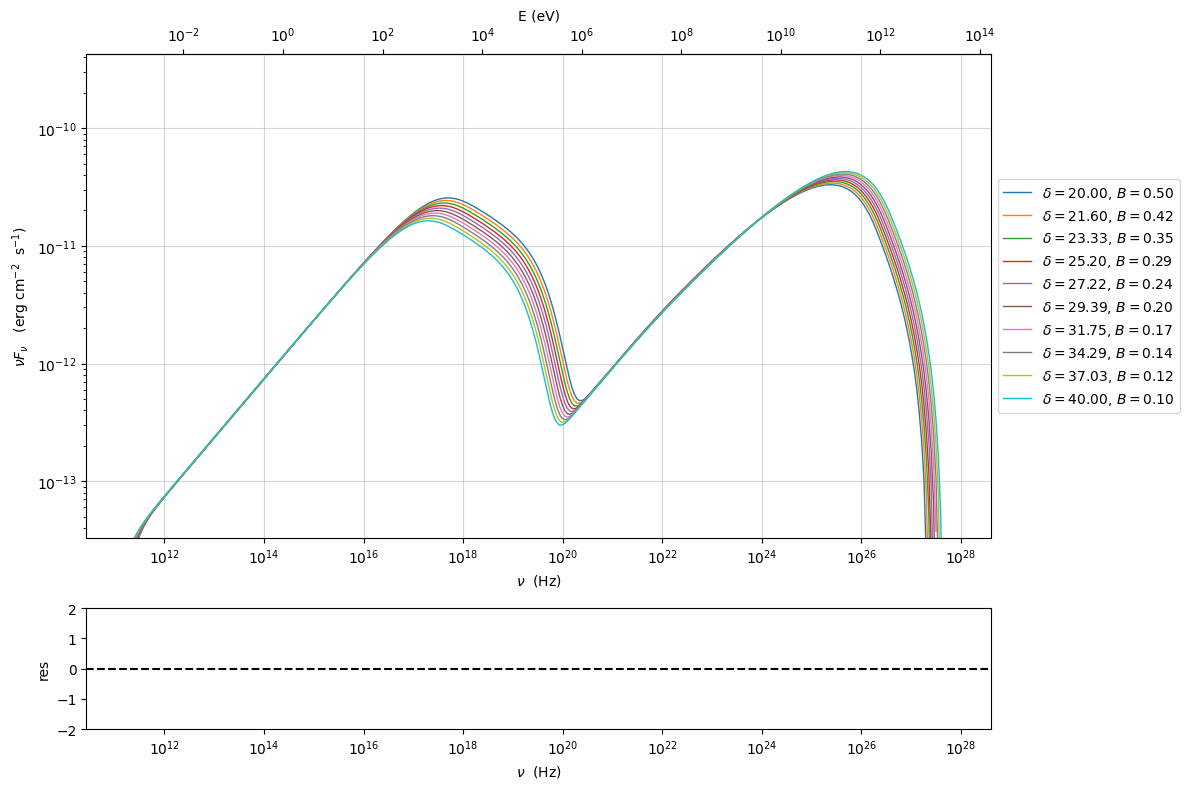

In [17]:
my_jet = Jet(name='B_delta_scan',electron_distribution='bkn')

my_jet.set_par('R',val=1e15)
my_jet.set_par('gmin',val=1e0)
my_jet.set_par('gmax',val=1e6)
my_jet.set_par('p',val=2.)
my_jet.set_par('p_1',val=3.5)
my_jet.set_par('N',val=1e5)
my_jet.set_par('gamma_break',val=1e5)

#create plotting objects
B_delta_scan = PlotSED()

#we scan a range of gamma_break values
B_scanned_values = np.geomspace(0.5, 0.1, num=10)
delta_scanned_values = np.geomspace(20, 40, num=10)

#create empty list to store the peak luminosity and frequencies of each component.
peak_frequency = []
peak_flux = []

peak_frequency_ssc = []
peak_flux_ssc = []


for B, delta in zip(B_scanned_values, delta_scanned_values):
 
    my_jet.set_par('B',val=B)
    my_jet.set_par('beam_obj',val=delta)

    my_jet.nu_seed_size = 1000
    my_jet.set_IC_nu_size(1000)
    
    my_jet.eval()
    my_jet.plot_model(plot_obj=B_delta_scan,label=r'$\delta$'+f'$={delta:.2f}$'+ ', $B$'+f'$={B:.2f}$', comp='Sum')
   
    x_p,y_p = my_jet.get_component_peak('Sync',log_log=True)
    x_p_SSC,y_p_SSC = my_jet.get_component_peak('SSC',log_log=True)
    
    peak_frequency.append(x_p)
    peak_flux.append(y_p) 

    peak_frequency_ssc.append(x_p_SSC)
    peak_flux_ssc.append(y_p_SSC) 


    
peak_frequency = np.asarray(peak_frequency)
peak_flux = np.asarray(peak_flux)

peak_frequency_ssc = np.asarray(peak_frequency_ssc)
peak_flux_ssc = np.asarray(peak_flux_ssc)

Let's now plot the $\frac{\nu^2_{IC, p}}{\nu_{sync, p}}$ ratio as function of $\delta$ & $B$:


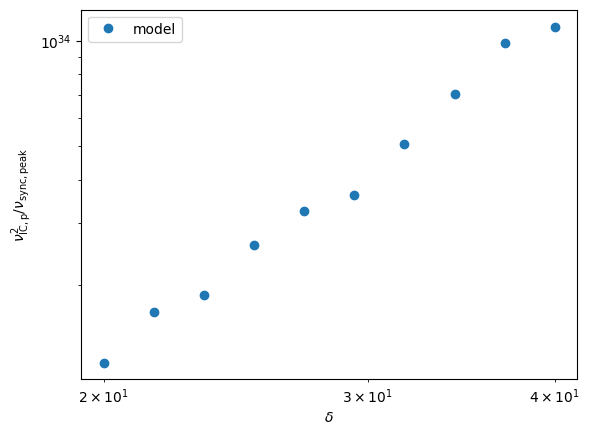

In [18]:
frequency_ratio = np.divide((10**peak_frequency_ssc)**2, 10**peak_frequency)

plt.figure()
plt.plot(delta_scanned_values,  frequency_ratio, 'o', label='model')

plt.xlabel(r'$\delta$')
plt.ylabel(r'$\nu^2_{\rm IC, p}/\nu_{\rm sync, peak}$')
plt.loglog()
plt.legend()

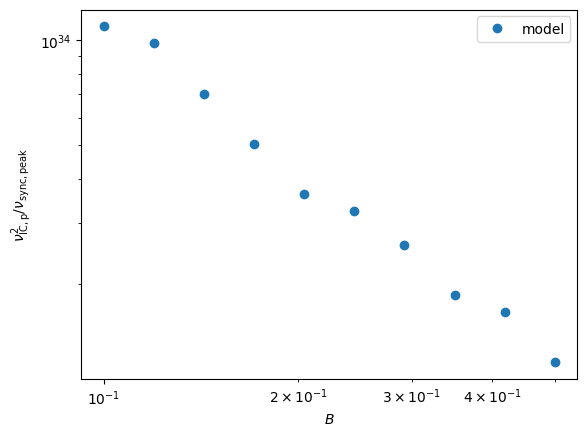

In [19]:
plt.figure()
plt.plot(B_scanned_values,  frequency_ratio, 'o', label='model')

plt.xlabel(r'$B$')
plt.ylabel(r'$\nu^2_{\rm IC, p}/\nu_{\rm sync, peak}$')
plt.loglog()
plt.legend()

This is one of the reason why "hard TeV" blazars, identified with $\nu_{\rm IC, p} > 1$ TeV require high $\delta$ and low magnetic fields in SSC models.<br>
Below is an example of modelling of the SED of the "hard TeV" blazar 1ES0229+200 from [Kaufmann+2011](https://ui.adsabs.harvard.edu/abs/2011A%26A...534A.130K/abstract). In this example,  
![1ES0229+200 SED model](./images/1ES0229_kaufmann2011.png)

### Energetic report
It is possible to get an energetic report of the jet model (updated each time that you eval the model). This report gives energy densities (U_) (both in the blob end disk restframe), the luminosities of the emitted components in the blob resftrame (L_), and the luminosity carried by the jet (jet_L) for the radiative components, the electrons, the magnetic fields, and for the cold protons in the jet. By default, JetSeT assumes one cold proton for each electron.

In [20]:
my_jet.energetic_report()

name,type,units,val
BulkLorentzFactor,jet-bulk-factor,,4.000000e+01
U_e,Energy dens. blob rest. frame,erg / cm3,9.929255e-01
U_p_cold,Energy dens. blob rest. frame,erg / cm3,1.503276e+02
U_B,Energy dens. blob rest. frame,erg / cm3,3.978874e-04
U_Synch,Energy dens. blob rest. frame,erg / cm3,2.776772e-03
U_Synch_DRF,Energy dens. disk rest. frame,erg / cm3,7.108536e+03
U_Disk,Energy dens. blob rest. frame,erg / cm3,0.000000e+00
U_BLR,Energy dens. blob rest. frame,erg / cm3,0.000000e+00
U_DT,Energy dens. blob rest. frame,erg / cm3,0.000000e+00
U_CMB,Energy dens. blob rest. frame,erg / cm3,0.000000e+00
